In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

2023-12-06 13:29:48.373332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 13:29:48.373420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 13:29:48.374625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 13:29:48.390626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 13:29:49.896032: W tensorflow/compiler/tf2

In [3]:
tf.keras.backend.clear_session()

In [4]:
# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train.reshape(-1, 784) / 255.0, X_test.reshape(-1, 784) / 255.0  # pixel values are scaled to the range [0, 1] by dividing by 255.0.
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10) # one-hot encoding
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000, 10) (10000, 10)


### Task: Automated Hyperparameter Tuning
1. Grid Search and Random Search: Introduce and apply Grid Search and Random Search using scikit-learn's GridSearchCV or RandomizedSearchCV.
2. Integration with Keras: Show how to use these methods with Keras models.

In [5]:
# Define a function to create a model (for KerasClassifier)
def model(num_layers, num_neurons, lr, activation_function):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(784,)))                           # input layer
    for _ in range(num_layers):                                                         # hidden layers
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))                          # output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Set up RandomizedSearchCV

model_to_search = KerasClassifier(
    model=model,
    batch_size=-1,
    verbose=0,
    epochs=50,
    validation_split=0.2,
    validation_batch_size=-1,
    num_layers = 1, # needs intitial combo of hyperparameters
    num_neurons = 32,
    lr = 0.001,
    activation_function = 'sigmoid' #optimizer is same as in model.compile
)

param_dist = {
    'lr': [0.001, 0.01, 0.1], 
    'num_neurons': [32, 64],  
    'num_layers':  [1, 2],
    'activation_function': ['relu', 'tanh', 'sigmoid']
}


random_grid = RandomizedSearchCV(estimator=model_to_search, param_distributions=param_dist, cv=3, n_iter=10) # will search 10 combinations

# Run grid search
estimator = random_grid.fit(X_train, y_train)
best_params = estimator.best_params_
print(best_params) # returns alternative with best accuracy @epochs irrespective of training/val behaviour

{'num_neurons': 64, 'num_layers': 1, 'lr': 0.01, 'activation_function': 'relu'}


## Training and Visualization of model with best params
Visualize the performance of the best model found by the search methods.

In [7]:
def train_and_evaluate_model(model, epochs):
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2)
    train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='val')
    plt.title(f'Accuracy (test accuracy = {test_accuracy:.4f})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.title(f'Loss (test loss = {test_loss:.4f})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()
    return test_loss, test_accuracy

In [8]:
best_model = model(**estimator.best_params_)

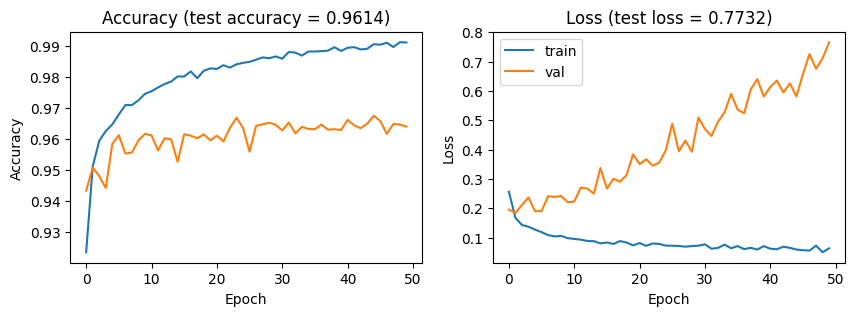

(0.7731616497039795, 0.9613999724388123)

In [9]:
train_and_evaluate_model(best_model, epochs=50)